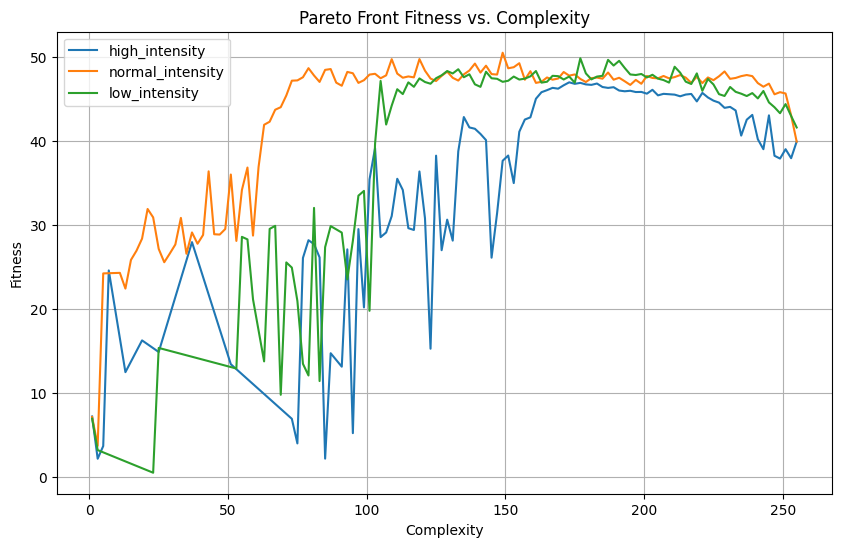

In [67]:
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np


def get_valid_data(save_path, env_name, device_name, pop_size, seed, other=None):

    FILE_NAME = os.path.join(save_path, f"{env_name}_{device_name}_{pop_size}_{seed}")
    if other:
        FILE_NAME = FILE_NAME + f"_{other}"

    with open(FILE_NAME + ".pkl", "rb") as f:
        pareto_front = pickle.load(f)

    fitness = pareto_front.fitness.cpu()
    complexity = np.arange(len(fitness))

    valid_complexity = []
    valid_fitness = []
    for c, f in zip(complexity, fitness):
        if f > 0 and c > 0 and c < 256:
            valid_complexity.append(c)
            valid_fitness.append(f)

    return valid_complexity, valid_fitness


x_1, y_1 = get_valid_data(
    save_path="./data",
    env_name="swimmer",
    device_name="4060Ti",
    pop_size=1000,
    seed=2,
    other="very_tiny_delete_high_intensity",
)
x_2, y_2 = get_valid_data(
    save_path="./data",
    env_name="swimmer",
    device_name="4060Ti",
    pop_size=1000,
    seed=2,
    other="very_tiny_delete_high_intensity",
)
x_3, y_3 = get_valid_data(
    save_path="./data",
    env_name="swimmer",
    device_name="4060Ti",
    pop_size=1000,
    seed=2,
    other="very_tiny_delete",
)
x_4, y_4 = get_valid_data(
    save_path="./data",
    env_name="swimmer",
    device_name="4060Ti",
    pop_size=1000,
    seed=2,
    other="very_tiny_delete_low_intensity",
)

# 绘制图表
plt.figure(figsize=(10, 6))
# plt.plot(x_1, y_1, linestyle="--", label="Growing(1000)")
plt.plot(x_2, y_2, label="high_intensity")
plt.plot(x_3, y_3, label="normal_intensity")
plt.plot(x_4, y_4, label="low_intensity")
plt.xlabel("Complexity")
plt.ylabel("Fitness")
plt.title("Pareto Front Fitness vs. Complexity")
plt.grid(True)
plt.legend()
plt.show()

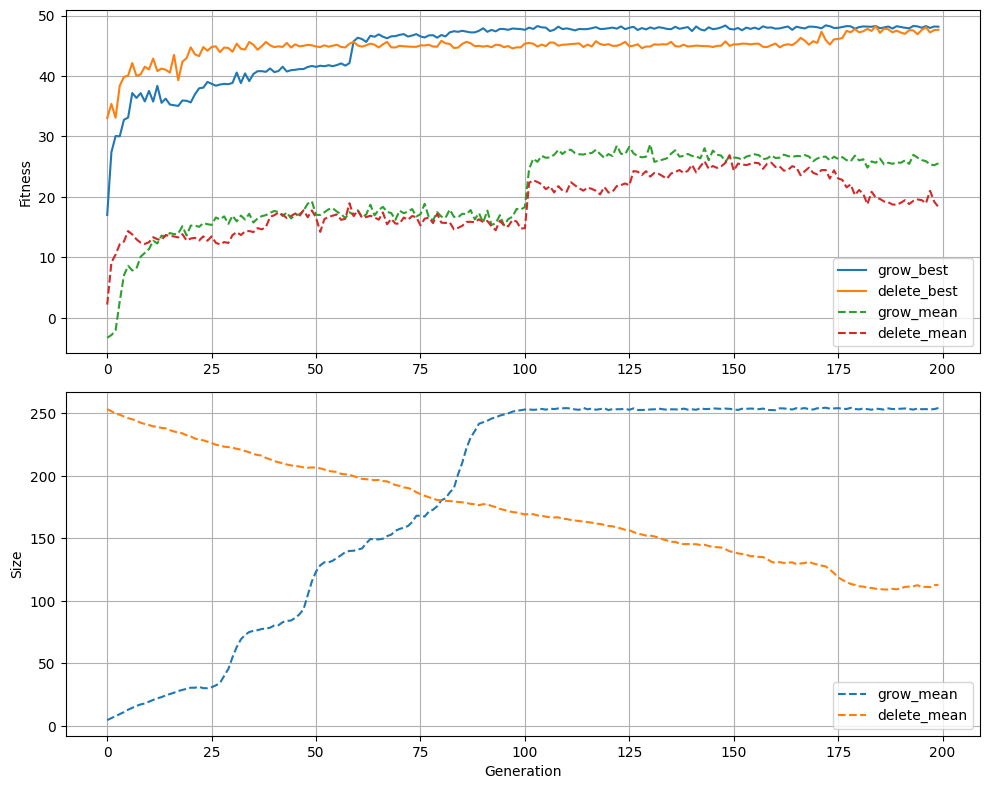

In [13]:
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def read_columns_with_pandas(save_path, env_name, device_name, pop_size, seed, other=None):
    FILE_NAME = os.path.join(save_path, f"{env_name}_{device_name}_{pop_size}_{seed}")
    if other:
        FILE_NAME = FILE_NAME + f"_{other}"
    df = pd.read_csv(FILE_NAME + ".csv")
    return {col: df[col].tolist() for col in df.columns}


data1 = read_columns_with_pandas(
    save_path="./data",
    env_name="swimmer",
    device_name="4060Ti",
    pop_size=1000,
    seed=3,
    other="no_delete",
)
data2 = read_columns_with_pandas(
    save_path="./data",
    env_name="swimmer",
    device_name="4060Ti",
    pop_size=1000,
    seed=3,
    other="very_tiny_delete",
)

import matplotlib.pyplot as plt

def plot_fitness_and_size(data1, data2):
    """
    Plot fitness and size comparison between two datasets.
    
    Parameters:
    - data1: First dataset (dict or DataFrame with 'generation', 'best_fitness', 'mean_fitness', 'best_size', 'mean_size')
    - data2: Second dataset (same structure as data1)
    """
    plt.figure(figsize=(10, 8))
    
    # Top plot - Fitness
    plt.subplot(2, 1, 1)
    plt.plot(data1['generation'], data1['best_fitness'], label="grow_best")
    plt.plot(data2['generation'], data2['best_fitness'], label="delete_best")
    plt.plot(data1['generation'], data1['mean_fitness'], '--', label="grow_mean")
    plt.plot(data2['generation'], data2['mean_fitness'], '--', label="delete_mean")
    plt.ylabel("Fitness")
    plt.grid(True)
    plt.legend()
    
    # Bottom plot - Size
    plt.subplot(2, 1, 2)
    # plt.plot(data1['generation'], data1['max_tree_size'], label="grow_max")
    # plt.plot(data2['generation'], data2['max_tree_size'], label="delete_max")
    plt.plot(data1['generation'], data1['mean_tree_size'], '--', label="grow_mean")
    plt.plot(data2['generation'], data2['mean_tree_size'], '--', label="delete_mean")
    plt.xlabel("Generation")
    plt.ylabel("Size")
    plt.grid(True)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_fitness_and_size(data1, data2)